# XAI for exploratory analysis

In [1]:
from typing import Any, List, Optional
import os, random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # noqa: F401 – needed by user modules
import shap, torch
from torch.utils.data import DataLoader

from src.preprocess.dataset      import Dataset, DatasetConfig
from src.preprocess.model_data   import ModelLoaders
from src.preprocess.result       import ResultData  # noqa: F401

window_size = 5
horizon     = 3

dataset_names: Optional[List[str]] = None

dataset      = Dataset(DatasetConfig(type="clean"))
result_data  = dataset.get()
ml           = ModelLoaders(df=result_data.ml_ready)

model_path   = f"data/20--model/LSTMws{window_size}h{horizon}.pt"
package      = ml.load(model_path)
y_true, y_pred = ml.test(ml.package)               # noqa: F841

model        = package.model.cpu().eval()
train_loader = package.train_loader
test_loader  = package.test_loader
feat_cols    = package.feat_cols
label_col    = package.label_col

[ModelLoaders] package loaded from PosixPath('data/20--model/LSTMws5h3.pt')
Test  MSE : 0.009216
Test  RMSE: 0.096001
Test  R²  : 0.9903


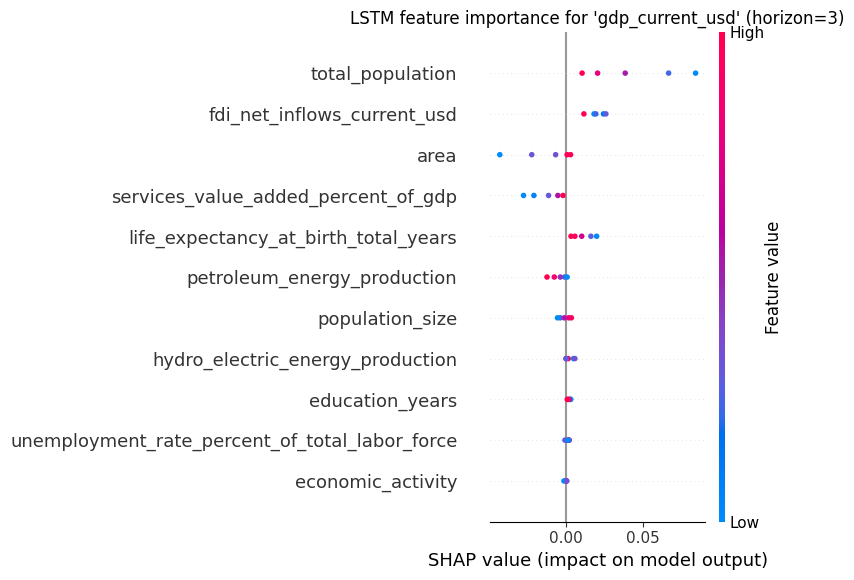

In [2]:
"""
End-to-end: load LSTM, compute SHAP (any horizon), aggregate to (time, feat),
and plot a dot summary.
"""



os.environ["CUDA_VISIBLE_DEVICES"] = ""  # CPU only
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

B = 32
bg_X, _ = next(iter(DataLoader(train_loader.dataset, batch_size=B, shuffle=False)))
bg_X = bg_X.detach().cpu()                       # (B, T, F)

explainer = shap.GradientExplainer(model, bg_X, local_smoothing=0)

Xs, _ = next(iter(test_loader))
Xs = Xs.detach().cpu()                           # (B*, T, F)

def aggregate_shap(raw_shap: Any, horizon: int) -> np.ndarray:
    """
    Return a (T, F) matrix, averaging over batch and, if present, horizon axes.
    Handles:
        • list  of length H where each entry is (B, T, F)
        • array with shape (B, T, F)                   – single-output
        • array with shape (B, T, F, H) or (B, H, T, F)– multi-output packed
    """
    if isinstance(raw_shap, list):                 # list → stack to (H, B, T, F)
        arr = np.stack([np.asarray(a) for a in raw_shap], axis=0)
        return arr.mean(axis=(0, 1))               # (T, F)

    arr = np.asarray(raw_shap)                     # ndarray
    if arr.ndim == 3:                              # (B, T, F)
        return arr.mean(axis=0)                    # (T, F)

    if arr.ndim == 4:
        # Identify which axis is horizon by size
        if arr.shape[-1] == horizon:               # (B, T, F, H)
            return arr.mean(axis=(0, -1))          # (T, F)
        if arr.shape[1]  == horizon:               # (B, H, T, F)
            return arr.mean(axis=(0, 1))           # (T, F)
    raise ValueError(f"Unrecognised SHAP shape {arr.shape} for horizon={horizon}")



raw_shap = explainer.shap_values(Xs)
s2d      = aggregate_shap(raw_shap, horizon)       # (T, F)
X_2d     = Xs.mean(dim=0).numpy()                  # (T, F)

assert s2d.shape == X_2d.shape == (Xs.shape[1], len(feat_cols)), \
    f"Shape mismatch: s2d={s2d.shape}, X_2d={X_2d.shape}, #feat_cols={len(feat_cols)}"

plt.figure(figsize=(14, 0.35 * len(feat_cols) + 2))
shap.summary_plot(
    s2d,
    X_2d,
    feature_names=feat_cols,
    plot_type="dot",
    max_display=len(feat_cols),
    show=False,
    rng=np.random.RandomState(SEED),
)
plt.title(f"LSTM feature importance for '{label_col}' (horizon={horizon})")
plt.tight_layout()
plt.show()
